# **Tarea 5. Analisis de resultados**

## **1. Parametrizacion de algoritmos:**
En esta tarea vamos a comparar diferentes algoritmos para resolver problemas de optimizacion
continua. Implementa los cambios necesarios para poder realizar las siguientes comparaciones:

* Parametros del Recocido simulado: Comparar al menos dos esquemas de enfriamiento.
* Parametros del Algoritmo genetico: Comparar los siguientes esquemas de reemplazo:
    * Generacional
    * Generacional con elitismo
    * Reemplazo de los peores
* Mejor parametrizacion: Recocido simulado vs algoritmo genetico


In [1]:
import numpy as np
import math
import random

#Implementamos todas las funciones a utilizar

def sphere(x):
    if x.ndim == 2 : 
        y = np.sum(x**2,axis=1)
    else: 
        y = np.sum(x**2)
    return y

def ackley(x):
    x = np.array(x)
    if x.ndim == 2 : 
        dim = x.shape[1]
        t1 = np.sum(x**2, axis=1)
        t2 = np.sum(np.cos(2 * np.pi * x), axis=1)
        y = -20 * np.exp(-0.2 * np.sqrt(t1 / dim)) - np.exp(t2 / dim) + 20 + np.exp(1)
    else: 
        t1 = -20*np.exp(-0.2*np.sqrt((1/len(x))*sum(x**2)))
        t2 = np.exp((1/len(x))*sum(np.cos(2*np.pi*x)))
        y = 20+t1-t2+np.exp(1)
    return y

def griewank(x):
    x = np.array(x)
    if x.ndim == 2: 
        i = np.array(range(1,x.shape[1]+1))
        t1 = np.sum(x**2, axis=1)/4000
        t2 = np.prod(np.cos(x/np.sqrt(i)))
    else: 
        i = np.array(range(1,len(x)+1))
        t1 = np.sum(x**2)/4000
        t2 = np.prod(np.cos(x/np.sqrt(i)))

    return 1 + t1 - t2

def rastrigin(x):
    x = np.array(x)
    if  x.ndim == 2: 
        t1 = 10*(x.shape[1])
        t2 = np.sum(x**2-10*np.cos(2*np.pi*x),axis=1)
    else: 
        i = np.array(range(1,len(x)+1))
        t1 = sum(x**2)/4000
        t2 = np.prod(np.cos(x/np.sqrt(i)))
    
    return t1 + t2

#La funcion aplica para parametros mayores o iguales a dos dimensiones
def rosenbrock(x):
    x = np.array(x)
    if  x.ndim == 2:
        x1 = x[:,1:]
        x0 = np.delete(x,0,axis = 1)
        t1 = 100*(x1-x0**2)**2
        t2 = (1-x0)**2 
        y = np.sum(t1 + t2,axis= 1)
    else: 
        x1 = x[1:]
        x0 = np.delete(x,-1)
        t1 = 100*(x1-x0**2)**2
        t2 = (1-x0)**2
        y = np.sum(t1 + t2)
    
    return y

# Implementamos ambos esquemas de enfriamiento
# temp: En ambos esquemas se refiere a la temperatura inicial
# beta y alpha: factores de enfriamiento
# t: numero de iteracion

def decremento_lento(temp,beta=0.1):
    return temp/(1+beta*temp)

def logaritmico(t,temp, alpha=0.95):
    return temp*alpha**t

def enfriamiento(esquema,t,temp,beta,alpha):
    evaluation = None
    if esquema == 'decremento':
        evaluation = decremento_lento(temp,beta)
    elif esquema == 'logaritmico':
        evaluation = logaritmico(t,temp,alpha)
    return evaluation

def vecino(solucion):
    neighbor = np.copy(solucion)
    #Ya que tenemos soluciones binarias y queremos generar un vecino de manera aleatoria
    #basta con generar el cambio de un bit de forma aleatoria
    indice = np.random.randint(len(neighbor))
    neighbor[indice] = 1 - neighbor[indice]
    return neighbor

# Implementamos esquemas de reemplazo
# Generamos una poblacion con la representacion binaria de soluciones
def poblacion(solution,nBit):
    #solution es el tamaño de la solucion que queremos generar
    #nBit es la cantidad de bit que queremos utilizar para representar la poblacion generada
    return np.random.randint(2,size = (solution,nBit))

# Seleccionamos los padres por medio del metodo de la ruleta
def ruleta(values):
    # Nos referimos a las aptitudes que posee cada individuo de la poblacion
    total = np.sum(values)
    probabilities = abs(values/total)
    parents = np.random.choice(np.arange(len(values)),size = 2, p = probabilities)
    return parents

# Operacion de cruza de n puntos
def cruza(parent_1,parent_2):
    cruce = np.random.randint(len(parent_1)-1)
    hijo_1 = np.concatenate((parent_1[:cruce],parent_2[cruce:]))
    hijo_2 = np.concatenate((parent_2[:cruce],parent_1[cruce:]))
    return hijo_1,hijo_2

def mutacion(individuo,probability):
    for i in range(len(individuo)):
        # A cada bit del individuo le asigamos una probabilidad de ser invertido
        # solo muta si esta es mayor a un numero aleatorio generado
        if np.random.rand() < probability:
            individuo[i] = 1 - individuo[i]
    return individuo

def generacional(population,values,new_population,new_values):
    population[:len(new_population)] = new_population
    values[:len(new_population)]= new_values
    return population, values

def elitismo(population,values,new_population,new_values):
    # Con argsort podemos extraer los indices de los valores mas pequeños que tenemos 
    index = np.argsort(values)[:len(new_population)]
    population[index] = new_population
    values[index]= new_values
    return population, values

def peores(population,values,new_population,new_values):
    index = np.flip(np.argsort(values)[:len(new_population)])
    population[index] = new_population
    values[index]= new_values
    return population, values

def reemplazo(esquema,population,values,new_population,new_values):
    remplace = None
    if esquema == 'generacional':
        remplace = generacional(population,values,new_population,new_values)
    elif esquema == 'elitismo':
        remplace = elitismo(population,values,new_population,new_values)
    elif esquema == 'peores':
        remplace = peores(population,values,new_population,new_values)
    return remplace

#Agregamos una funcion auxiliar para evaluar las soluciones
def evalua(function,x):
    evaluation = None
    if function == 'sphere':
        evaluation = sphere(x)
    elif function == 'ackley':
        evaluation = ackley(x)
    elif function == 'griewank':
        evaluation = griewank(x)
    elif function == 'rastrigin':
        evaluation = rastrigin(x)
    elif function == 'rosenbrock':
        evaluation = rosenbrock(x)
    return evaluation

In [2]:
def recocido_simulado(temperatura_inicial,temperatura_final,funcion, dimension,esquema_enfriamiento,beta=0.01,alpha =0.95):
    mejor_solucion = np.random.randint(2,size = dimension)
    mejor_evaluacion = evalua(funcion,mejor_solucion)
    temperatura = temperatura_inicial
    t = 0

    while temperatura > temperatura_final:
        #Generamos el vecino a evaluar
        t += 1
        nueva_solucion = vecino(mejor_solucion)
        nueva_evaluacion = evalua(funcion,nueva_solucion)
        delta = nueva_evaluacion - mejor_evaluacion
        probabilidad = np.exp(-delta/temperatura)
        #Debido a que no todas las funciones necesitan perturbaciones similares
        #establecemos un criterio de aceptacion de probabilidad arbitrario aleatorio
        criterio = random.random()

        if nueva_evaluacion < mejor_evaluacion:
            mejor_solucion = nueva_solucion
            mejor_evaluacion = nueva_evaluacion
            #Si la probabilidad de que la solucion sea mejor es mayor a nuestro criterio
            #aleatorio, entonces aceptamos la nueva solucion generada
        elif probabilidad > criterio:
            mejor_solucion = nueva_solucion
            mejor_evaluacion = nueva_evaluacion

        #Aplicamos el esquema de enfriamiento para reducir la temperatura constantemente
        temperatura = enfriamiento(esquema_enfriamiento,t,temperatura,beta,alpha)
    
    return mejor_solucion, mejor_evaluacion

In [3]:
def algoritmo_genetico(generation,pob, nBit, probability,function,replace):
    # generation: se refiere al numero de iteraciones de realizaremos
    # pob: tamaño de la poblacion que queremos generar
    # nBit: cantidad de Bits con los que queremos representar la poblacion
    # function: funcion que queremos optimizar
    population = poblacion(pob,nBit)
    
    mejor_solucion = []
    mejor_evaluacion = []

    # Aplicamos el criterio de paro, para un numero determinado de generaciones
    for i in range(generation): 
        evaluation = evalua(function,population)
        new_population = []
        new_evaluation = []
        for j in range(pob // 2):
            parents = ruleta(evaluation)
            padre_1,padre_2 =  population[parents]
            hijo_1,hijo_2 = cruza(padre_1, padre_2)
            muta_1 = mutacion(hijo_1, probability)
            muta_2 = mutacion(hijo_2, probability)
            value_1 = evalua(function,muta_1)
            value_2 = evalua(function,muta_2)
            new_evaluation.append(value_1)
            new_evaluation.append(value_2)
            new_population.append(muta_1)
            new_population.append(muta_2)

        new_population = np.array(new_population)
        population, evaluation = reemplazo(replace,population,evaluation,new_population,new_evaluation)
        index = np.argsort(evaluation)[0]
        mejor_evaluacion.append(min(evaluation))
        mejor_solucion.append(population[index])
        

    return mejor_evaluacion,mejor_solucion


In [4]:
#Ejemplo de uso de el algoritmo genetico, podemos utilizar los argumentos de los nombres de las funciones,
#asi como el esquema de reemplazo que queremos utilizar
algoritmo_genetico(30,1000, 10, 0.1,'ackley','peores')

([1.2257411716696964,
  1.2257411716696964,
  0.0,
  1.2257411716696964,
  0.0,
  1.2257411716696964,
  1.2257411716696964,
  1.2257411716696964,
  1.2257411716696964,
  1.2257411716696964,
  1.7111871278556592,
  1.2257411716696964,
  1.2257411716696964,
  0.0,
  1.2257411716696964,
  1.2257411716696964,
  1.2257411716696964,
  1.2257411716696964,
  0.0,
  0.0,
  1.2257411716696964,
  1.2257411716696964,
  1.2257411716696964,
  1.2257411716696964,
  1.2257411716696964,
  1.2257411716696964,
  1.2257411716696964,
  1.2257411716696964,
  1.2257411716696964,
  1.2257411716696964],
 [array([1, 1, 1, 0, 0, 0, 1, 1, 1, 1]),
  array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1]),
  array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0]),
  array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0]),
  array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1]),
  array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0]),
  array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1]),
  array([1, 0, 0, 1, 1, 1, 1, 1, 0, 1]),
  array([0, 1, 1, 0, 1, 0, 1, 0, 0, 0]),
  array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1]),
  ar

In [5]:
#Ejemplo de uso del algoritmo de recocido simulado, se puede utilizar como argumento el
# esquema de enfriamiento "logaritmico" o "decremento"
recocido_simulado(1000,0.2,'griewank', 10,'logaritmico',beta=0.01,alpha =0.95)

(array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0]), 0.5403985400025814)

## **Ejercicio 2. Experimentación en Optimización continua**

  * Realizar al menos 30 repeticiones para diferentes funciones de prueba de
    optimización continua (sphere, ackley, griewank, rastrigin, rosenbrock), en dimensión 10

  * Fijar criterio de término para todas las ejecuciones, de manera que se tenga una
    comparación justa (por ejemplo con tiempo total de ejecución)

  * El programa deberá imprimir como salida la semilla del generador de números
    aleatorios que se utilizó para la ejecución
    
  * El programa deberá permitir ingresar (como parámetro opcional) la semilla del
    generador de aleatorios con las que se hará la ejecución. Si no se indica nada, el
    programa deberá generar una semilla adecuada

Una vez realizado lo anterior, se debera realizar lo siguiente:

  * Tabla de configuración de parámetros para los diferentes algoritmos (o estrategias) trabajados 
      (sphere, ackley, griewank, rastrigin, rosenbrock)

  * Gráficas de evolución de aptitud para diferentes ejecuciones

  * Gráficas de evolución promedio de aptitud. Una gráfica por cada ejemplar
      En esta gráfica deberían aparecer todas los algoritmos (estrategias) que se compararon

  * Tabla de resultados con datos estadísticos (mejor, peor, media, mediana, desviación
      estándar, número de iteraciones o generaciones, etc..)

  * Gráficas de diversidad
      Se deben implementar al menos dos medidas de distancia
      Para cada medida se deben incluir las gráficas correspondientes

  * Gráficas de entropía

  * BoxPlot, uno por cada ejemplar

In [7]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def ejecutar_experimentos(funciones, dimension=10, repeticiones=30, semilla=None):
    resultados = []

    # Configuracion de semilla aleatoria si no se proporciona una
    if semilla is None:
        semilla = np.random.randint(12099)
    np.random.seed(semilla)
    print("Semilla del generador de numeros aleatorios utilizada:", semilla)

    for funcion in funciones:
        resultados_funcion = []
        for _ in range(repeticiones):
            inicio = time.time()

            # Ejecutamos el algoritmo genetico con esquema generacional
            mejor_aptitud_genetico_gen, _ = algoritmo_genetico(30, 1000, dimension, 0.1, funcion, 'generacional')
            tiempo_generacional = time.time() - inicio

            inicio = time.time()

            # Ejecutamos el algoritmo genetico con esquema generacional con elitismo
            mejor_aptitud_genetico_elite, _ = algoritmo_genetico(30, 1000, dimension, 0.1, funcion, 'elitismo')
            tiempo_elitismo = time.time() - inicio

            inicio = time.time()

            # Ejecutamos el algoritmo genetico con esquema reemplazo de los peores
            mejor_aptitud_genetico_peor, _ = algoritmo_genetico(30, 1000, dimension, 0.1, funcion, 'peores')
            tiempo_peor = time.time() - inicio

            inicio = time.time()

            # Ejecutamos recocido simulado con esquema logaritmico
            _, mejor_aptitud_log = recocido_simulado(1000, 0.2, funcion, dimension, 'logaritmico', beta=0.01, alpha=0.95)
            tiempo_logaritmico = time.time() - inicio

            inicio = time.time()

            # Ejecutamos recocido simulado con esquema de decremento lento
            _, mejor_aptitud_decremento = recocido_simulado(1000, 0.2, funcion, dimension, 'decremento', beta=0.01, alpha=0.95)
            tiempo_decremento = time.time() - inicio

            resultados_funcion.append({
                'Funcion': funcion,
                'Algoritmo': 'Algoritmo Genetico (Generacional)',
                'Mejor Aptitud': min(mejor_aptitud_genetico_gen),
                'Tiempo': tiempo_generacional
            })

            resultados_funcion.append({
                'Funcion': funcion,
                'Algoritmo': 'Algoritmo Genetico (Elitismo)',
                'Mejor Aptitud': min(mejor_aptitud_genetico_elite),
                'Tiempo': tiempo_elitismo
            })

            resultados_funcion.append({
                'Funcion': funcion,
                'Algoritmo': 'Algoritmo Genetico (Reemplazo de los peores)',
                'Mejor Aptitud': min(mejor_aptitud_genetico_peor),
                'Tiempo': tiempo_peor
            })

            resultados_funcion.append({
                'Funcion': funcion,
                'Algoritmo': 'Recocido Simulado (Logaritmico)',
                'Mejor Aptitud': mejor_aptitud_log,
                'Tiempo': tiempo_logaritmico
            })

            resultados_funcion.append({
                'Funcion': funcion,
                'Algoritmo': 'Recocido Simulado (Decremento Lento)',
                'Mejor Aptitud': mejor_aptitud_decremento,
                'Tiempo': tiempo_decremento
            })

        resultados.extend(resultados_funcion)

    return resultados

# Ejecutamos las funciones
funciones = ['sphere', 'ackley', 'griewank', 'rastrigin', 'rosenbrock']
resultados_experimentos = ejecutar_experimentos(funciones, dimension=10, repeticiones=30)

Semilla del generador de numeros aleatorios utilizada: 2180


In [25]:
resultados_experimentos

[{'Funcion': 'sphere',
  'Algoritmo': 'Algoritmo Genetico (Generacional)',
  'Mejor Aptitud': 0,
  'Tiempo': 1.5239992141723633},
 {'Funcion': 'sphere',
  'Algoritmo': 'Algoritmo Genetico (Elitismo)',
  'Mejor Aptitud': 1,
  'Tiempo': 1.4329030513763428},
 {'Funcion': 'sphere',
  'Algoritmo': 'Algoritmo Genetico (Reemplazo de los peores)',
  'Mejor Aptitud': 1,
  'Tiempo': 1.4321107864379883},
 {'Funcion': 'sphere',
  'Algoritmo': 'Recocido Simulado (Logaritmico)',
  'Mejor Aptitud': 5,
  'Tiempo': 0.0},
 {'Funcion': 'sphere',
  'Algoritmo': 'Recocido Simulado (Decremento Lento)',
  'Mejor Aptitud': 0,
  'Tiempo': 0.007978677749633789},
 {'Funcion': 'sphere',
  'Algoritmo': 'Algoritmo Genetico (Generacional)',
  'Mejor Aptitud': 0,
  'Tiempo': 1.4266819953918457},
 {'Funcion': 'sphere',
  'Algoritmo': 'Algoritmo Genetico (Elitismo)',
  'Mejor Aptitud': 0,
  'Tiempo': 1.427319049835205},
 {'Funcion': 'sphere',
  'Algoritmo': 'Algoritmo Genetico (Reemplazo de los peores)',
  'Mejor Aptit

In [10]:
# Tabla de configuracion de parametros
parametros = {
    'Funcion': ['sphere', 'ackley', 'griewank', 'rastrigin', 'rosenbrock'],
    'Algoritmo': ['Recocido Simulado', 'Recocido Simulado', 'Algoritmo Genetico', 'Algoritmo Genetico', 'Algoritmo Genetico'],
    'Esquema de Enfriamiento': ['Logaritmico', 'Decremento Lento', '', '', ''],
    'Esquema de Reemplazo': ['', '', 'Generacional', 'Elitismo', 'Peores']
}

df_parametros = pd.DataFrame(parametros)
print(df_parametros)

      Funcion           Algoritmo Esquema de Enfriamiento Esquema de Reemplazo
0      sphere   Recocido Simulado             Logaritmico                     
1      ackley   Recocido Simulado        Decremento Lento                     
2    griewank  Algoritmo Genetico                                 Generacional
3   rastrigin  Algoritmo Genetico                                     Elitismo
4  rosenbrock  Algoritmo Genetico                                       Peores


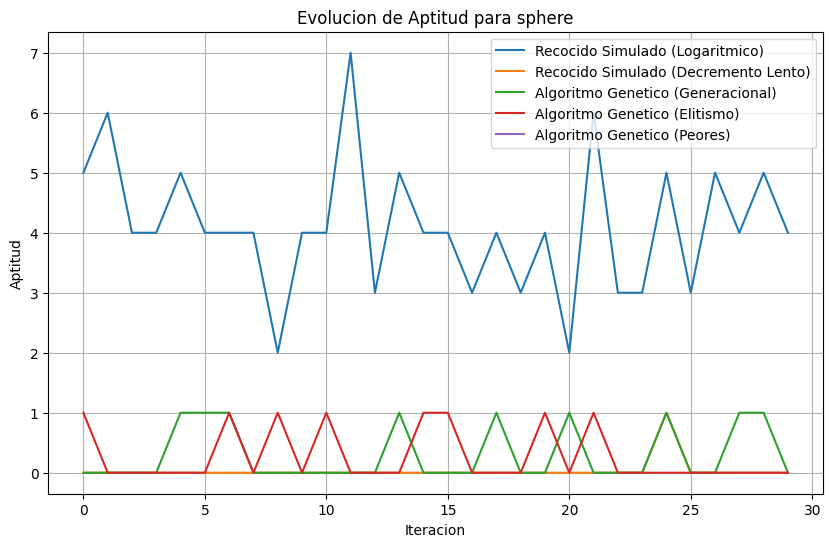

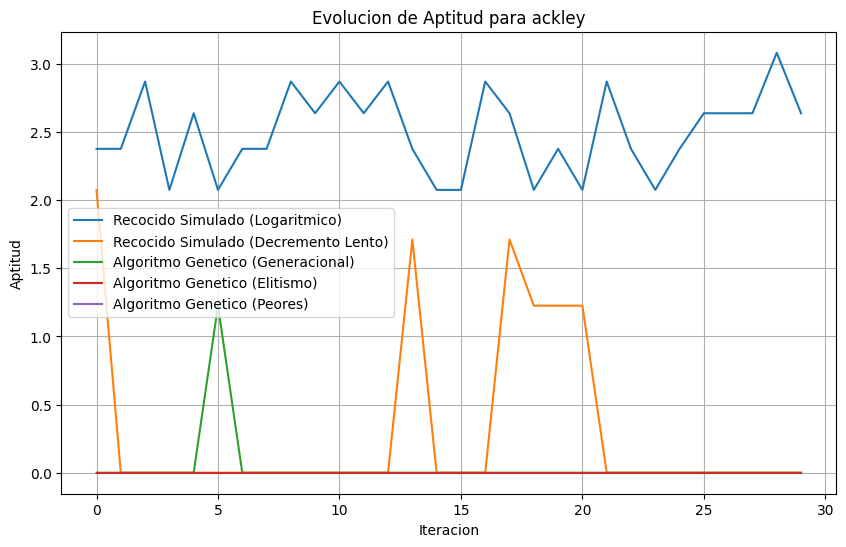

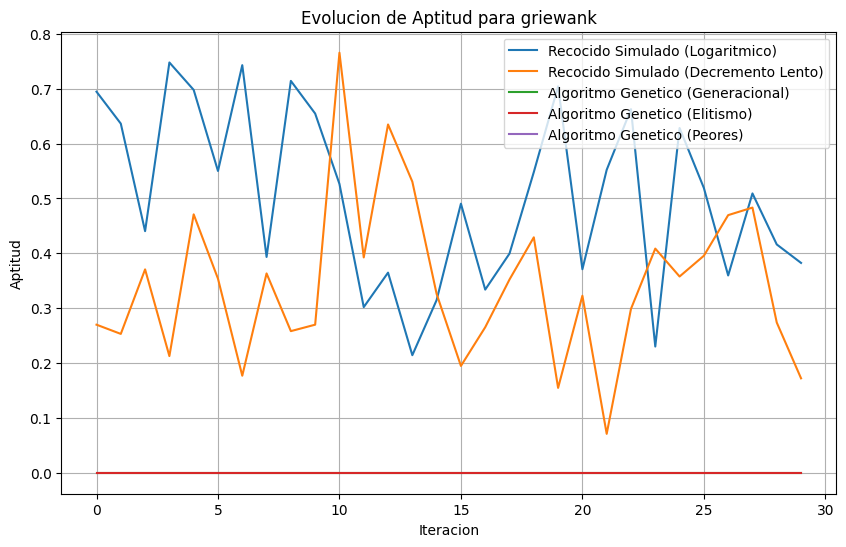

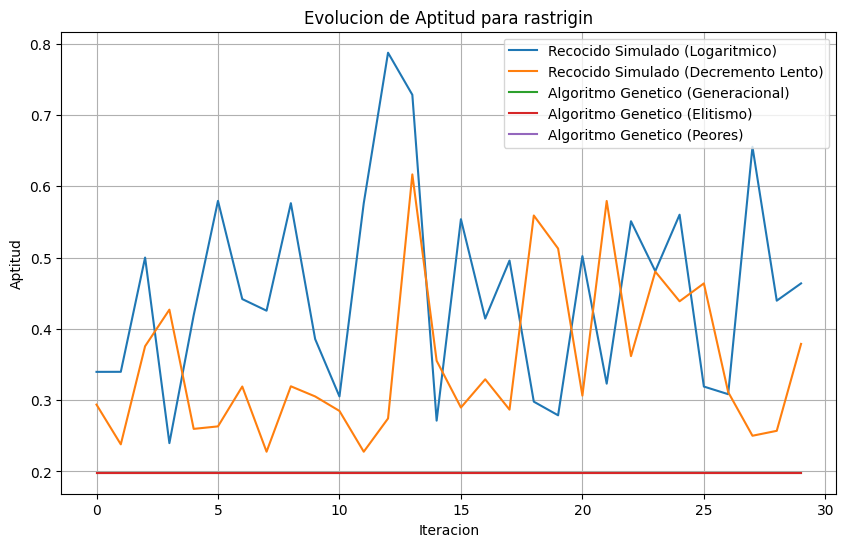

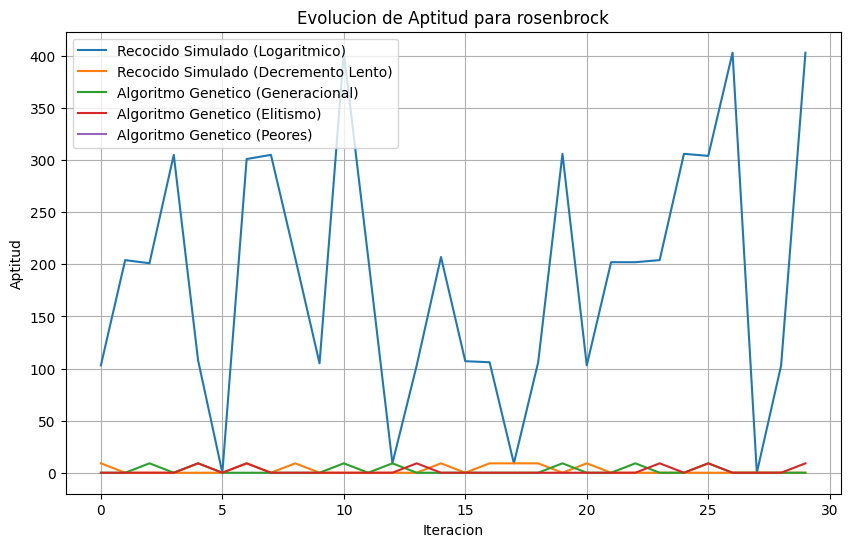

In [12]:
# Funcion para graficar la evolucion de aptitud
def graficar_evolucion_aptitud(resultados, funcion):
    plt.figure(figsize=(10, 6))
    for algoritmo in ['Recocido Simulado (Logaritmico)', 'Recocido Simulado (Decremento Lento)', 'Algoritmo Genetico (Generacional)','Algoritmo Genetico (Elitismo)','Algoritmo Genetico (Peores)']:
        aptitudes = [r['Mejor Aptitud'] for r in resultados if r['Funcion'] == funcion and r['Algoritmo'] == algoritmo]
        plt.plot(range(len(aptitudes)), aptitudes, label=algoritmo)
    plt.title(f'Evolucion de Aptitud para {funcion}')
    plt.xlabel('Iteracion')
    plt.ylabel('Aptitud')
    plt.legend()
    plt.grid(True)
    plt.show()

# Graficamos evolucion de aptitud para cada funcion
for funcion in funciones:
    graficar_evolucion_aptitud(resultados_experimentos, funcion)

In [13]:
# Calculo de estadisticas

# Convertimos resultados a DataFrame
df_resultados = pd.DataFrame(resultados_experimentos)

# Calculamos las estadisticas
estadisticas = df_resultados.groupby(['Funcion', 'Algoritmo']).agg({
    'Mejor Aptitud': ['min', 'max', 'mean', 'median', 'std'],
    'Tiempo': ['mean']
}).reset_index()

print(estadisticas)

       Funcion                                     Algoritmo Mejor Aptitud  \
                                                                       min   
0       ackley                 Algoritmo Genetico (Elitismo)      0.000000   
1       ackley             Algoritmo Genetico (Generacional)      0.000000   
2       ackley  Algoritmo Genetico (Reemplazo de los peores)      0.000000   
3       ackley          Recocido Simulado (Decremento Lento)      0.000000   
4       ackley               Recocido Simulado (Logaritmico)      2.075155   
5     griewank                 Algoritmo Genetico (Elitismo)      0.000000   
6     griewank             Algoritmo Genetico (Generacional)      0.000000   
7     griewank  Algoritmo Genetico (Reemplazo de los peores)      0.000000   
8     griewank          Recocido Simulado (Decremento Lento)      0.070832   
9     griewank               Recocido Simulado (Logaritmico)      0.214229   
10   rastrigin                 Algoritmo Genetico (Elitismo)    

c:\Users\danaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\danaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


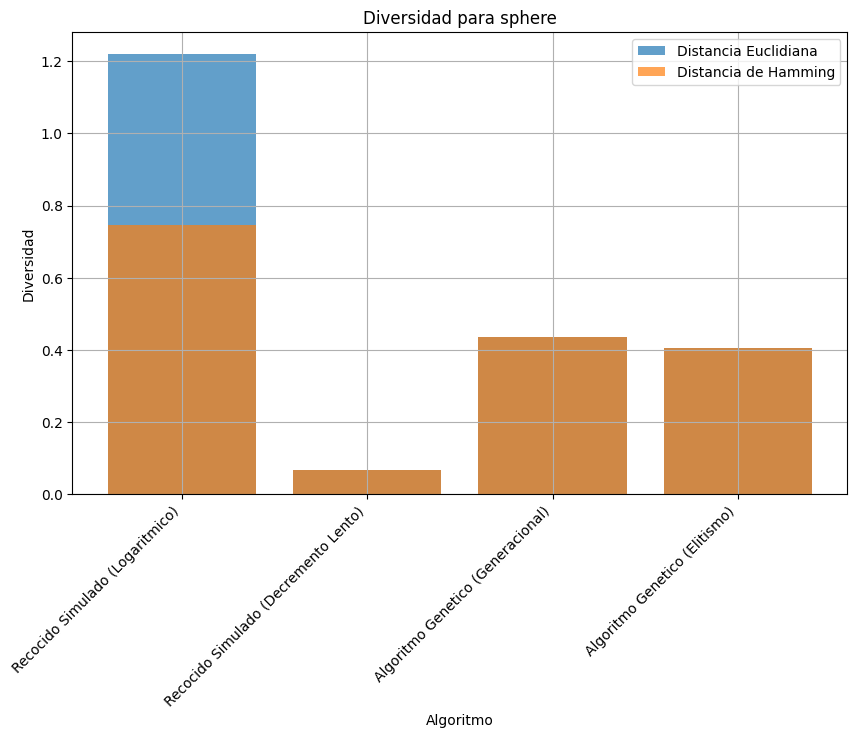

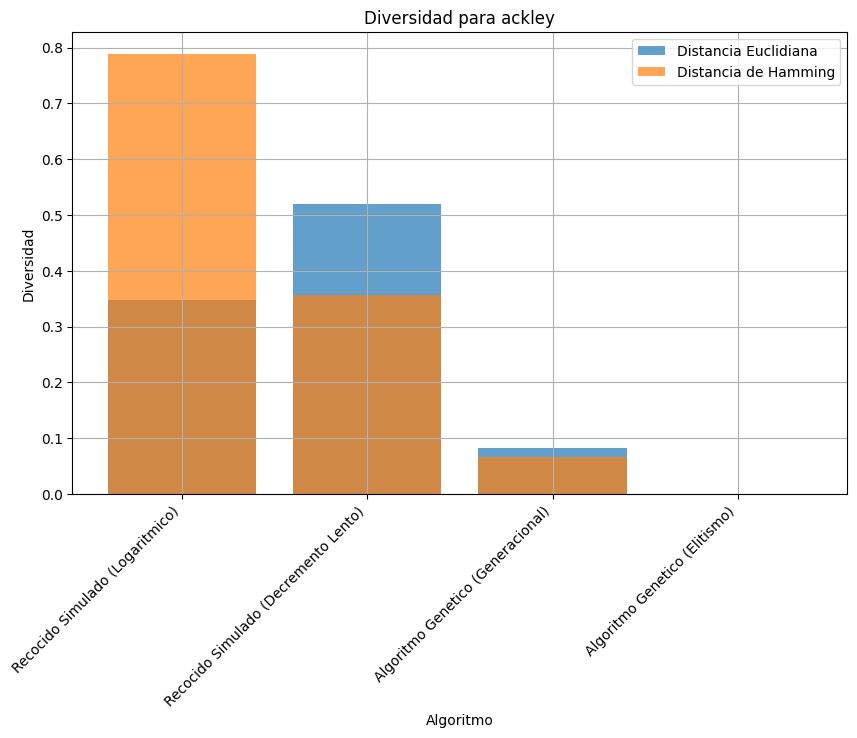

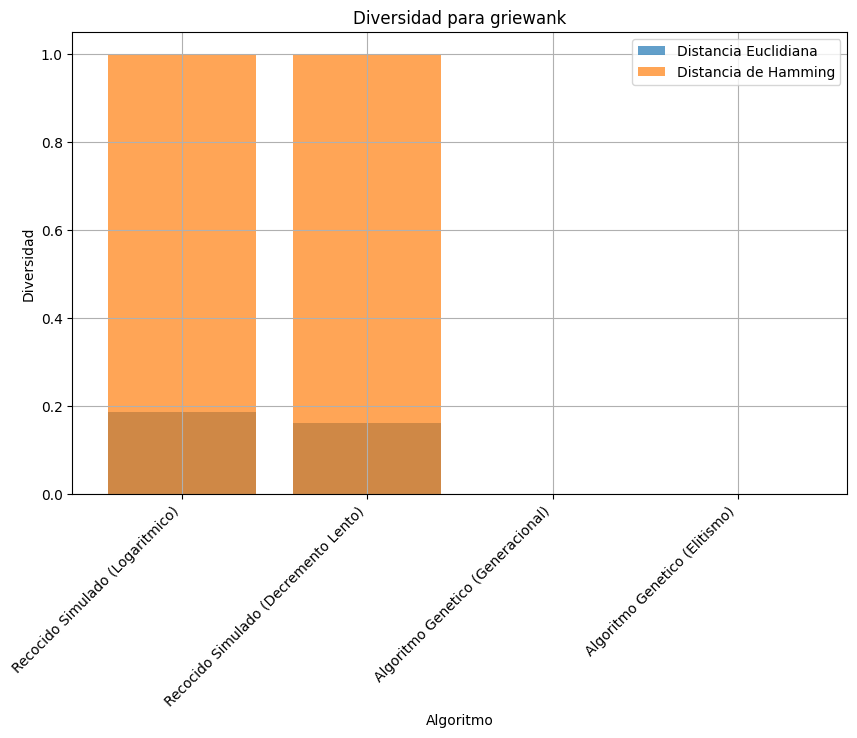

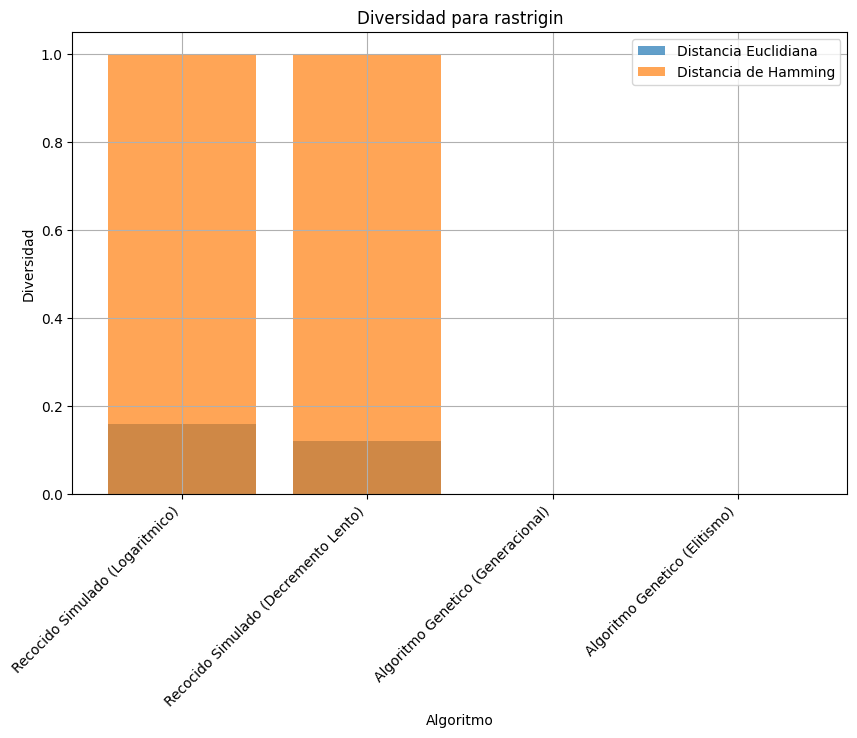

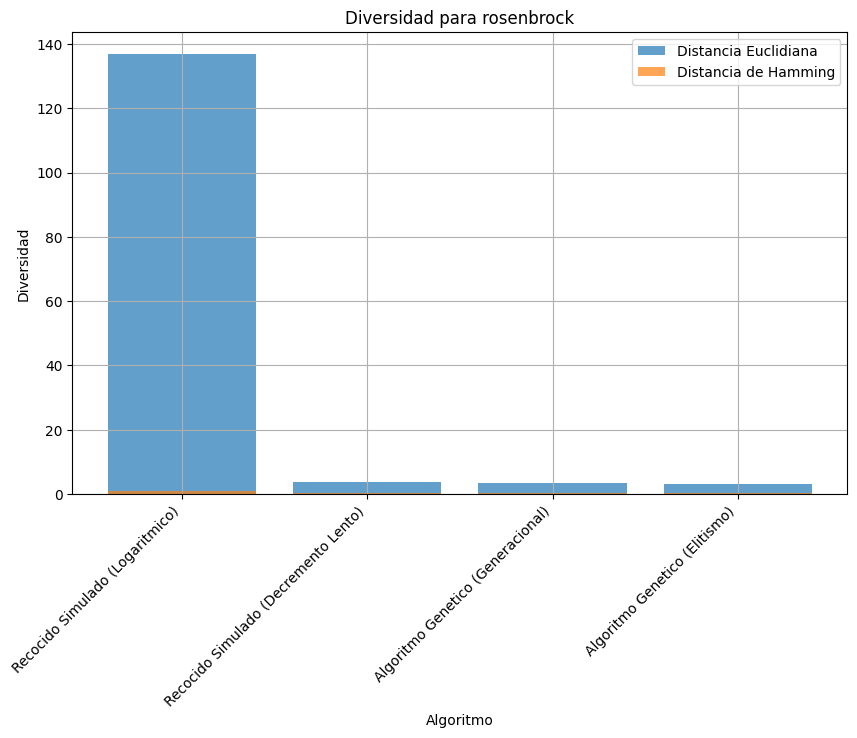

In [26]:
# Graficas de Diversidad

# Funcion para calcular la diversidad utilizando distancia euclidiana
def calcular_diversidad_euclidiana(soluciones):
    return np.mean([np.linalg.norm(soluciones[i] - soluciones[j]) for i in range(len(soluciones)) for j in range(i + 1, len(soluciones))])

# Funcion para calcular la diversidad utilizando distancia de Hamming
def calcular_diversidad_hamming(soluciones):
    return np.mean([np.count_nonzero(soluciones[i] != soluciones[j]) for i in range(len(soluciones)) for j in range(i + 1, len(soluciones))])

# Funcion para graficar la diversidad
def graficar_diversidad(resultados, funcion):
    diversidades_euclidiana = []
    diversidades_hamming = []
    algoritmos = ['Recocido Simulado (Logaritmico)', 'Recocido Simulado (Decremento Lento)', 'Algoritmo Genetico (Generacional)','Algoritmo Genetico (Elitismo)','Algoritmo Genetico (Peores)']
    for algoritmo in algoritmos:
        soluciones = [r['Mejor Aptitud'] for r in resultados if r['Funcion'] == funcion and r['Algoritmo'] == algoritmo]
        diversidades_euclidiana.append(calcular_diversidad_euclidiana(soluciones))
        diversidades_hamming.append(calcular_diversidad_hamming(soluciones))

    plt.figure(figsize=(10, 6))
    plt.bar(algoritmos, diversidades_euclidiana, label='Distancia Euclidiana', alpha=0.7)
    plt.bar(algoritmos, diversidades_hamming, label='Distancia de Hamming', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Diversidad para {funcion}')
    plt.xlabel('Algoritmo')
    plt.ylabel('Diversidad')
    plt.legend()
    plt.grid(True)
    plt.show()

# Graficamos la diversidad para cada funcion
for funcion in funciones:
    graficar_diversidad(resultados_experimentos, funcion)

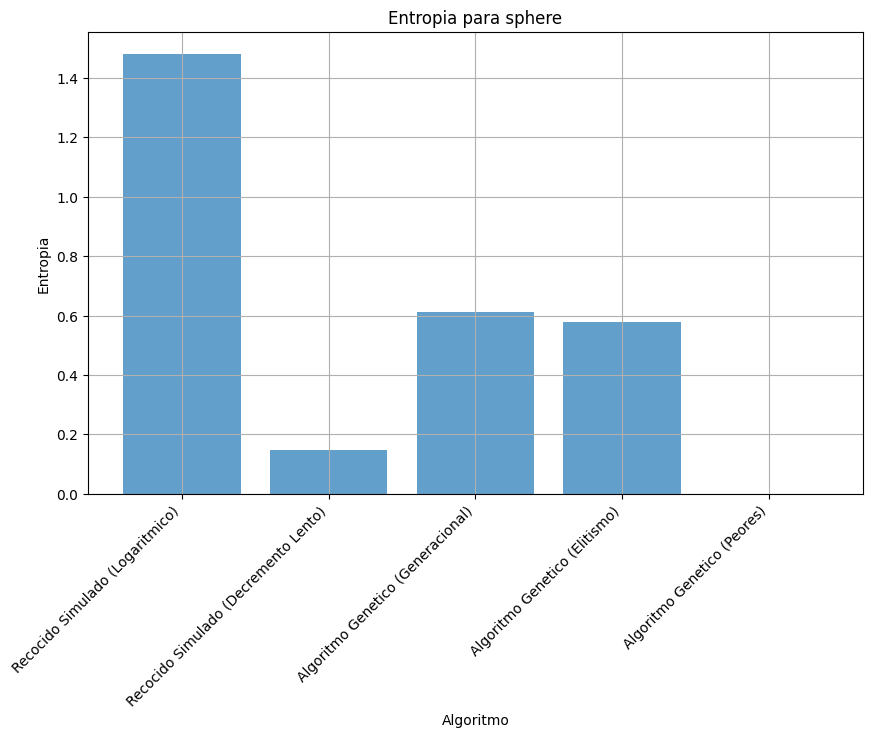

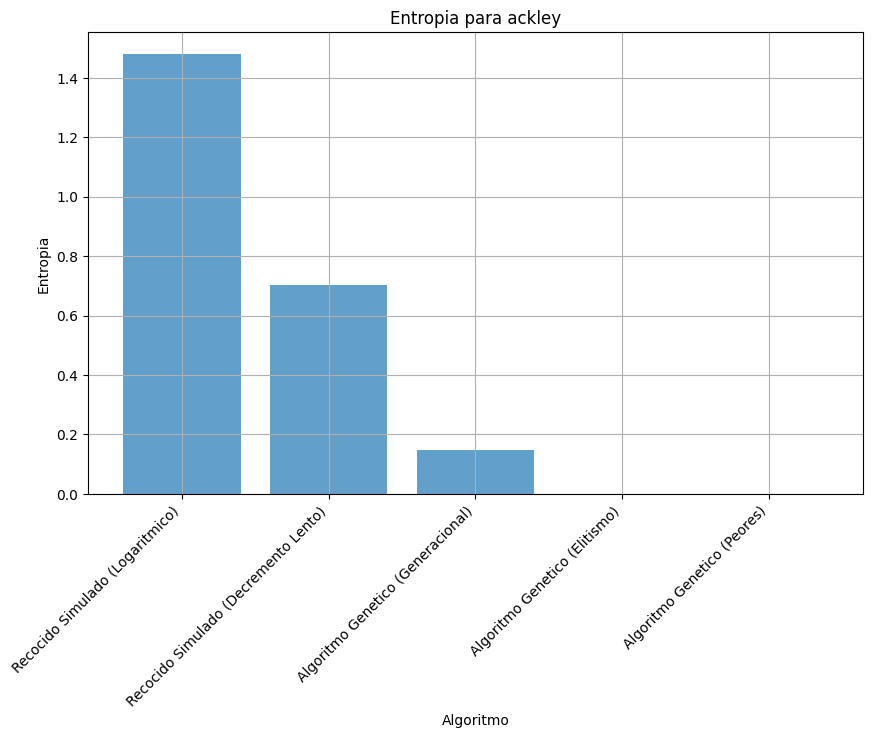

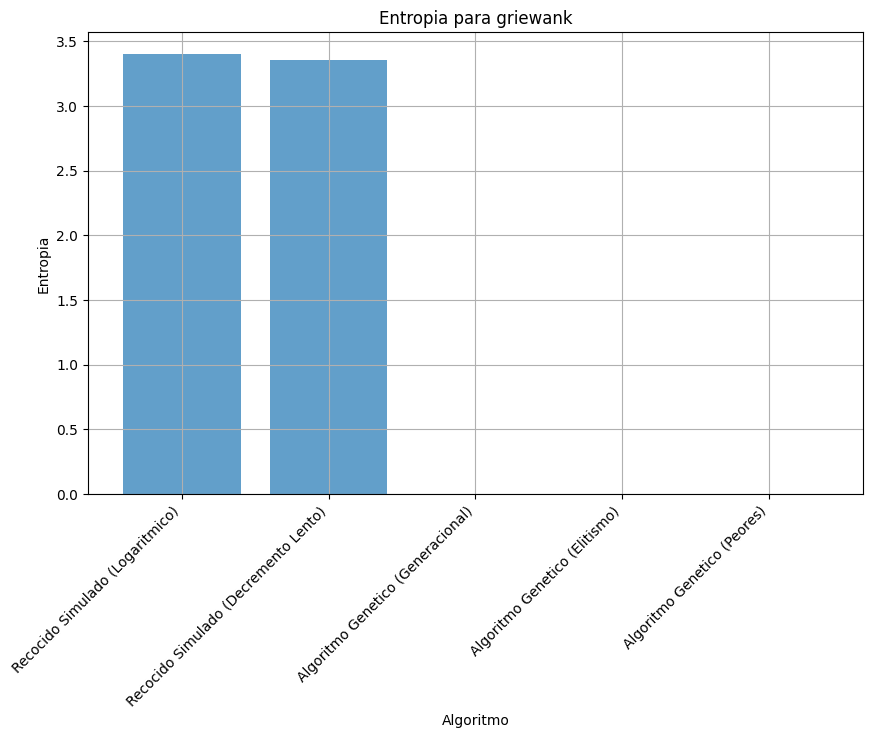

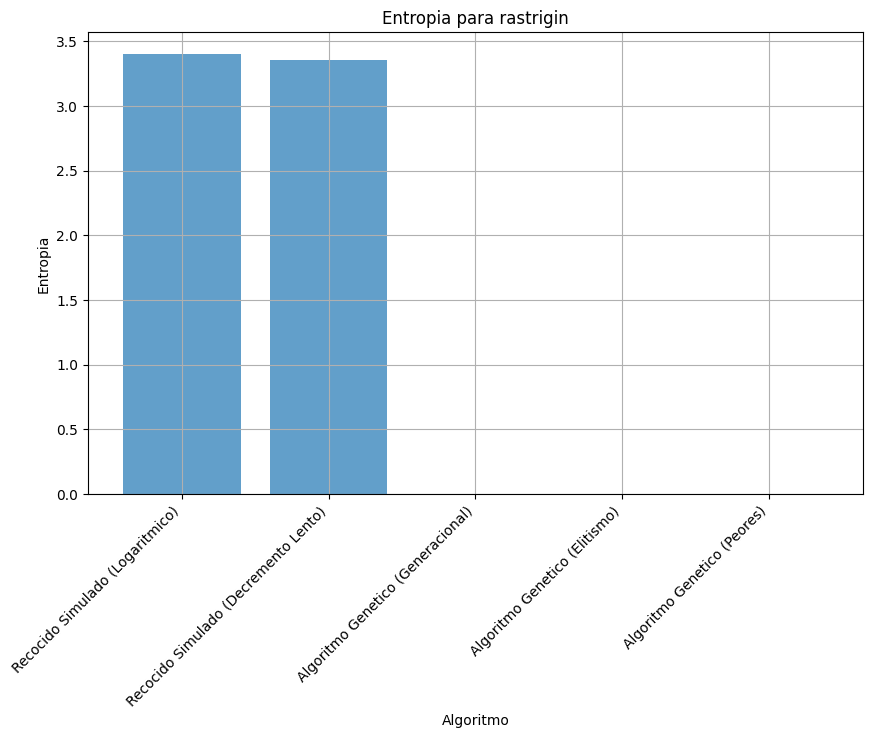

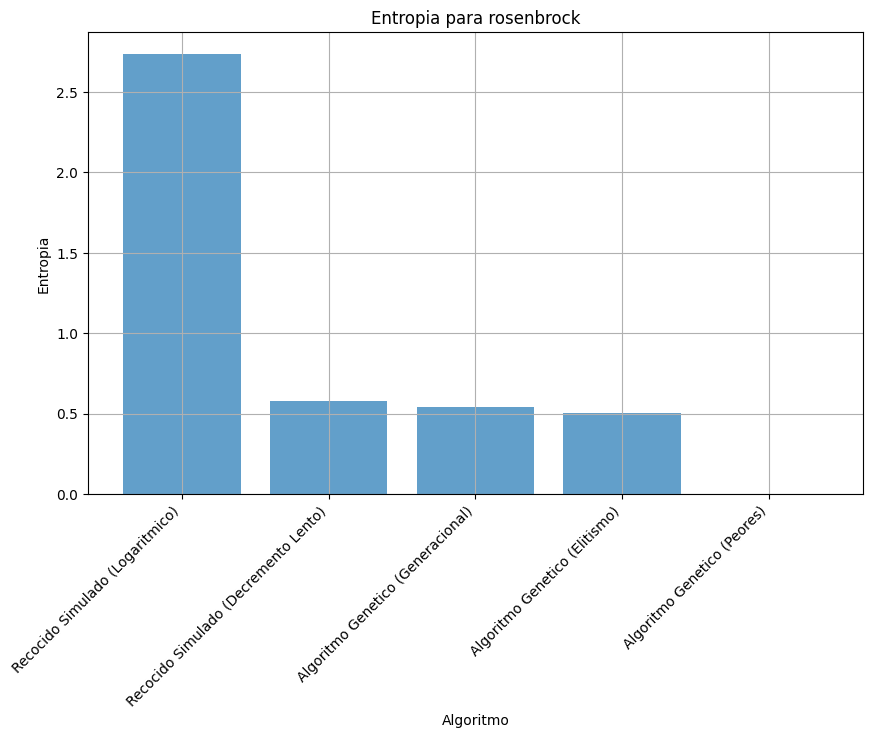

In [22]:
# Entropia
# Funcion para calcular la entropia
def calcular_entropia(soluciones):
    frecuencia = np.unique(soluciones, return_counts=True)[1]
    probabilidad = frecuencia / np.sum(frecuencia)
    return -np.sum(probabilidad * np.log(probabilidad))

# Funcion para graficar la entropia
def graficar_entropia(resultados, funcion):
    entropias = []
    algoritmos = ['Recocido Simulado (Logaritmico)', 'Recocido Simulado (Decremento Lento)', 'Algoritmo Genetico (Generacional)','Algoritmo Genetico (Elitismo)','Algoritmo Genetico (Peores)']
    for algoritmo in algoritmos:
        soluciones = [r['Mejor Aptitud'] for r in resultados if r['Funcion'] == funcion and r['Algoritmo'] == algoritmo]
        entropias.append(calcular_entropia(soluciones))

    plt.figure(figsize=(10, 6))
    plt.bar(algoritmos, entropias, alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Entropia para {funcion}')
    plt.xlabel('Algoritmo')
    plt.ylabel('Entropia')
    plt.grid(True)
    plt.show()

# Graficamos la entropia para cada funcion
for funcion in funciones:
    graficar_entropia(resultados_experimentos, funcion)

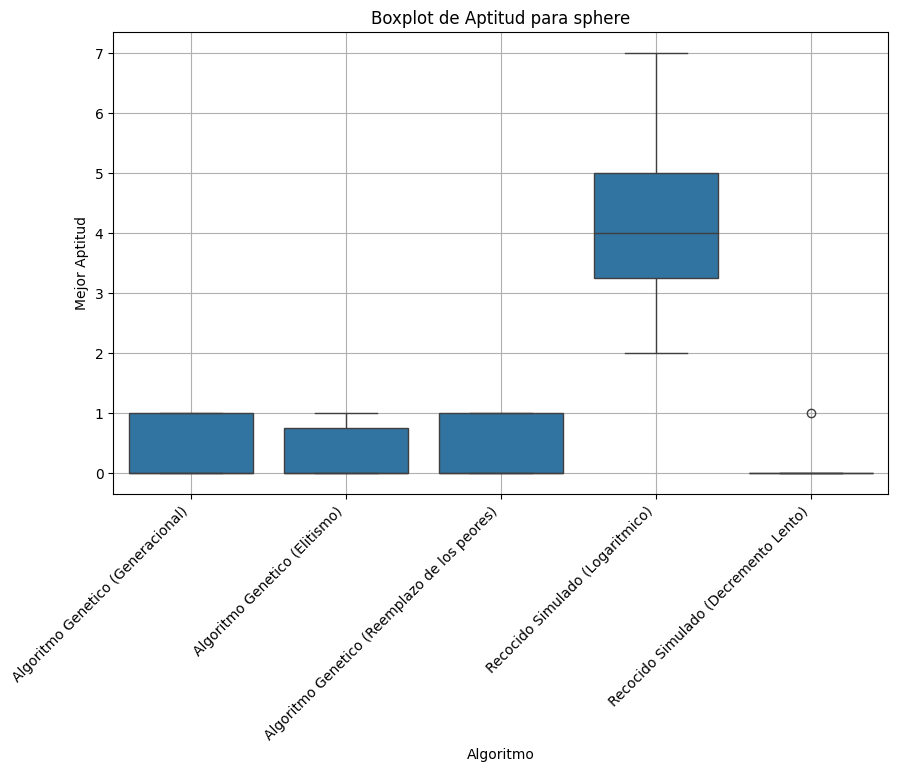

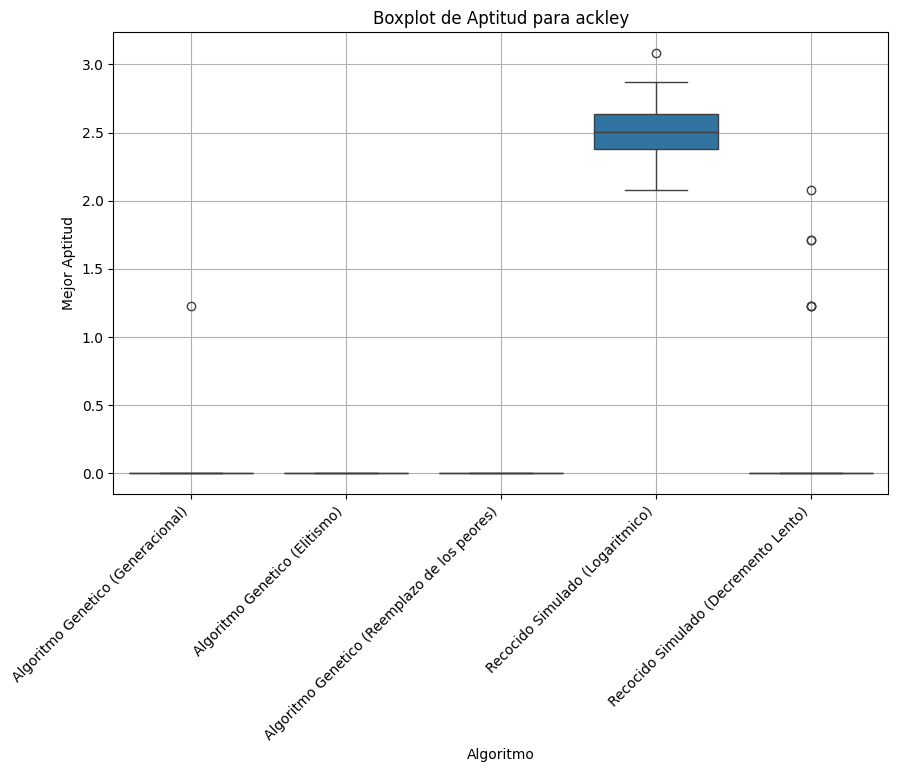

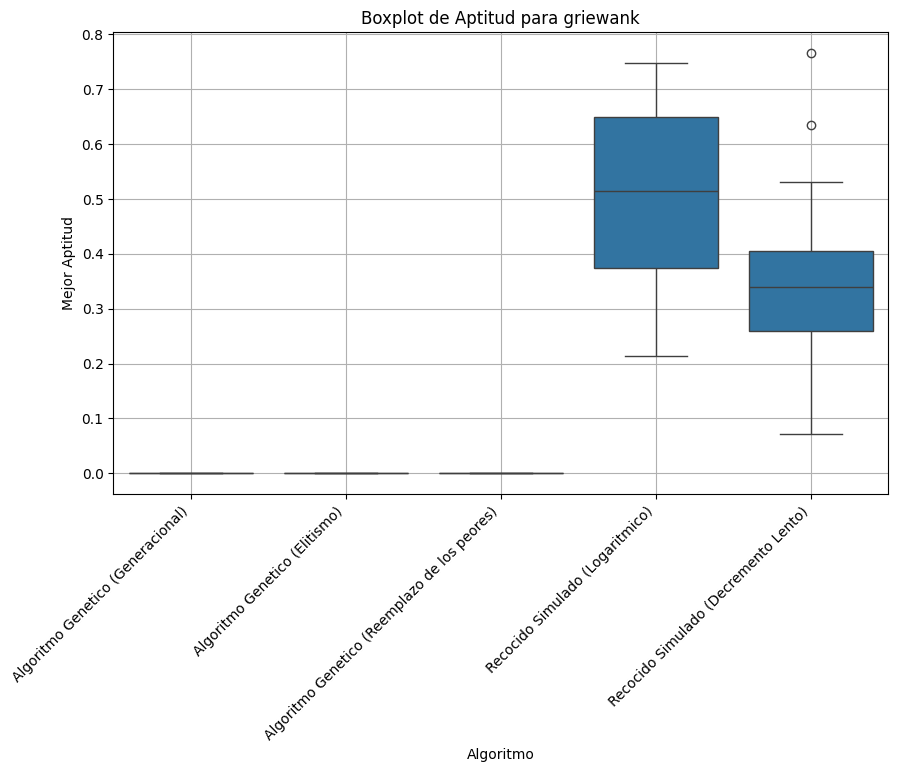

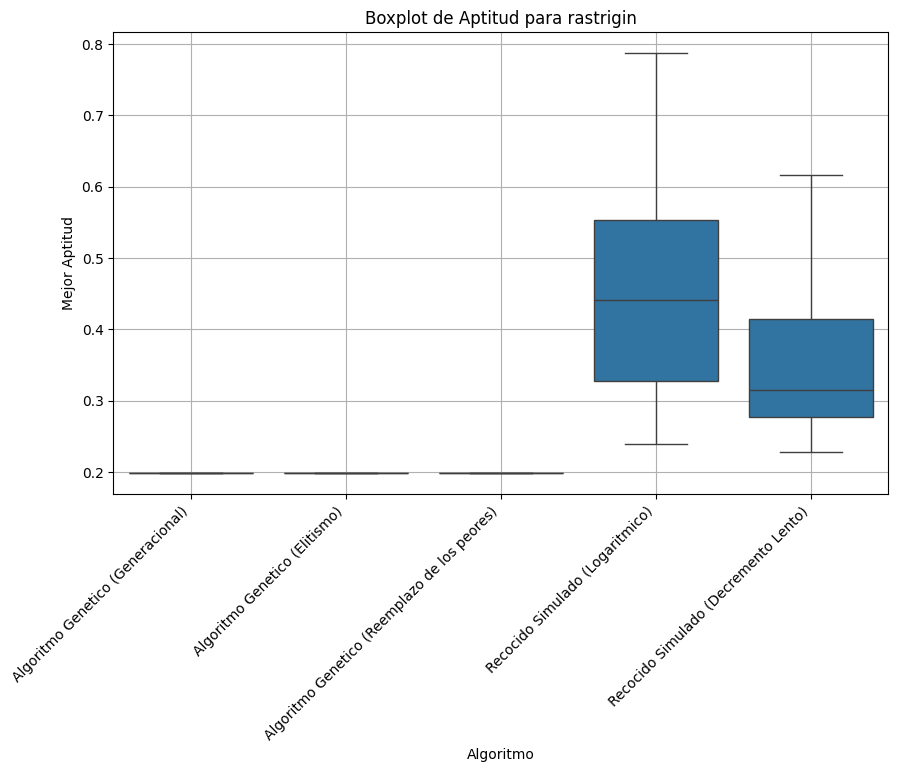

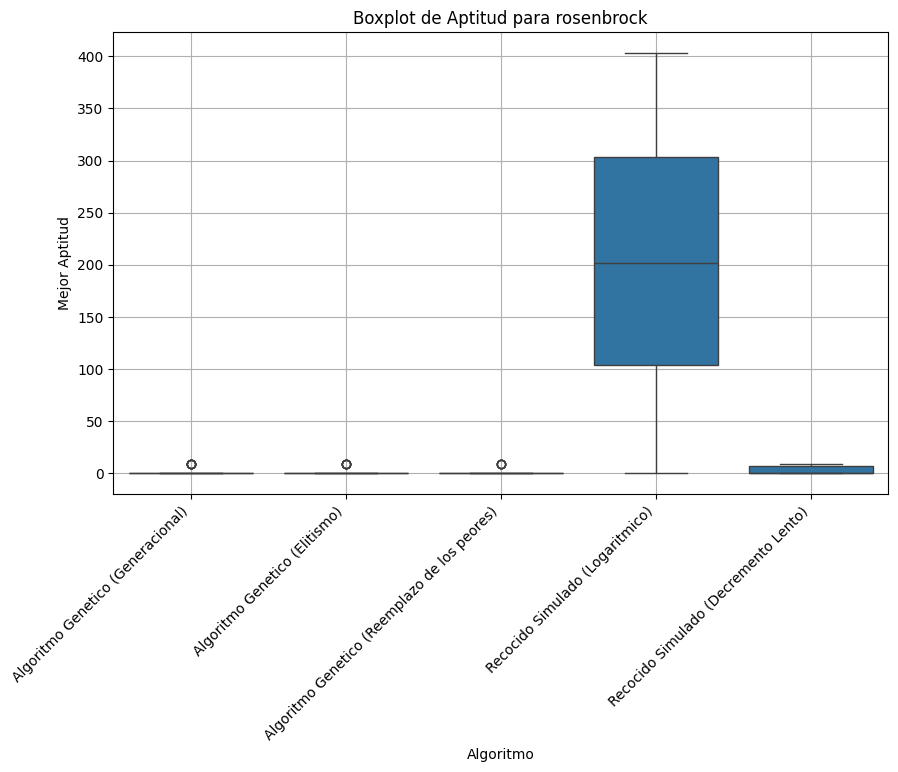

In [23]:
# Boxplots
# Funcion para graficar boxplots
def graficar_boxplots(resultados, funcion):
    plt.figure(figsize=(10, 6))
    df_funcion = df_resultados[df_resultados['Funcion'] == funcion]
    sns.boxplot(x='Algoritmo', y='Mejor Aptitud', data=df_funcion)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Boxplot de Aptitud para {funcion}')
    plt.xlabel('Algoritmo')
    plt.ylabel('Mejor Aptitud')
    plt.grid(True)
    plt.show()

# Graficamos los boxplots para cada funcion
for funcion in funciones:
    graficar_boxplots(resultados_experimentos, funcion)

In [17]:
# Guardado de resultados
df_resultados.to_csv('resultados_experimentos.csv', index=False)
df_parametros.to_csv('configuracion_parametros.csv', index=False)
estadisticas.to_csv('estadisticas_resultados.csv', index=False)

In [18]:
pd.read_csv('resultados_experimentos.csv')

,Funcion,Algoritmo,Mejor Aptitud,Tiempo
0,sphere,Algoritmo Genetico (Generacional),0.0,1.523999
1,sphere,Algoritmo Genetico (Elitismo),1.0,1.432903
2,sphere,Algoritmo Genetico (Reemplazo de los peores),1.0,1.432111
3,sphere,Recocido Simulado (Logaritmico),5.0,0.000000
4,sphere,Recocido Simulado (Decremento Lento),0.0,0.007979
...,...,...,...,...
745,rosenbrock,Algoritmo Genetico (Generacional),0.0,1.849008
746,rosenbrock,Algoritmo Genetico (Elitismo),9.0,1.858877
747,rosenbrock,Algoritmo Genetico (Reemplazo de los peores),0.0,1.864279
748,rosenbrock,Recocido Simulado (Logaritmico),403.0,0.000000


In [19]:
pd.read_csv('configuracion_parametros.csv')

,Funcion,Algoritmo,Esquema de Enfriamiento,Esquema de Reemplazo
0,sphere,Recocido Simulado,Logaritmico,NaN
1,ackley,Recocido Simulado,Decremento Lento,NaN
2,griewank,Algoritmo Genetico,NaN,Generacional
3,rastrigin,Algoritmo Genetico,NaN,Elitismo
4,rosenbrock,Algoritmo Genetico,NaN,Peores


In [20]:
pd.read_csv('estadisticas_resultados.csv')

,Funcion,Algoritmo,Mejor Aptitud,Mejor Aptitud.1,Mejor Aptitud.2,Mejor Aptitud.3,Mejor Aptitud.4,Tiempo
0,NaN,NaN,min,max,mean,median,std,mean
1,ackley,Algoritmo Genetico (Elitismo),0.0,0.0,0.0,0.0,0.0,1.8335885047912597
2,ackley,Algoritmo Genetico (Generacional),0.0,1.2257411716696964,0.04085803905565655,0.0,0.22378869646210164,1.8388344844182332
3,ackley,Algoritmo Genetico (Reemplazo de los peores),0.0,0.0,0.0,0.0,0.0,1.838966139157613
4,ackley,Recocido Simulado (Decremento Lento),0.0,2.0751545922899837,0.30582507876701304,0.0,0.6396131441435065,0.010544824600219726
5,ackley,Recocido Simulado (Logaritmico),2.0751545922899837,3.081625695846352,2.498024235969545,2.5069456822256946,0.3050176537920063,0.00043283303578694663
6,griewank,Algoritmo Genetico (Elitismo),0.0,0.0,0.0,0.0,0.0,1.8349883000055949
7,griewank,Algoritmo Genetico (Generacional),0.0,0.0,0.0,0.0,0.0,1.8332496166229248
8,griewank,Algoritmo Genetico (Reemplazo de los peores),0.0,0.0,0.0,0.0,0.0,1.8379029035568237
9,griewank,Recocido Simulado (Decremento Lento),0.07083227021794813,0.7655469047953132,0.3431969233780594,0.3390394360449455,0.14554318475454686,0.01315898895263672
